In [30]:
# --------------------------------
# Name: plot_lengthscales_error.ipynb
# Author: Brian R. Greene
# University of Oklahoma
# Created: 13 April 2021
# Purpose: read output from integral_lengthscale.py to plot
# Updates 
# 26 April 2021 -- read from new A_interp sims (only 128 is ready)
# --------------------------------

In [69]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

In [72]:
# Configure plots
rc('font',weight='normal',size=20,family='serif',serif='Computer Modern Roman')
rc('text',usetex='True')

In [70]:
class simulation():
    """Contains simulation parameters and can read averaged csv files
    
    :var dict xytavg: averages of instantaneous variables in x,y,t dimensions
    :var dict cov: covariances of instantaneous variables averaged in x,y,t dimensions
    :var dict most: monin-obukhov similarity parameters
    """
    def __init__(self, path, nx, ny, nz, Lx, Ly, Lz, stab):
        """Creates a simulation object with appropriate setup parameters
        :param string path: absolute path to simulation output directory
        :param int nx: number of grid points in x-dimension
        :param int ny: number of grid points in y-dimension
        :param int nz: number of grid points in z-dimension
        :param float Lx: physical length of x-dimension in meters
        :param float Ly: physical length of y-dimension in meters
        :param float Lz: physical length of z-dimension in meters
        :param str stab: HBZ cooling rate label (A-F)
        """
        # initialize with args
        self.path = path
        self.nx = nx
        self.ny = ny
        self.nz = nz
        self.Lx = Lx
        self.Ly = Ly
        self.Lz = Lz
        self.stab = stab
        
        # calculate dx, dy, dz, nt
        self.dx = self.Lx/float(self.nx)
        self.dy = self.Ly/float(self.ny)
        self.dz = self.Lz/float(self.nz-1)
        
        # create label
        self.lab = str(self.nx).zfill(3)
        
        # initialize empty dicts for averaged and covariance vars
        self.xytavg = {}
        self.cov = {}
        self.var = {}
        self.Ri = {}
        self.most = {}
        self.tke = {} # tke budget terms
        
        # initialize empty z variable
        self.z = None
        self.h = None
        
    def read_csv(self):
        print(f"Beginning loading data for {self.nx}^3 simulation--")
        print(f"Reading file: {self.path}")
        
        data = np.genfromtxt(self.path, dtype=float, delimiter=",", skip_header=1)
        # assign each column to parameters
        # columns are:
        # z, ubar, vbar, wbar, Tbar, uw_cov_res, uw_cov_tot,
        # vw_cov_res, vw_cov_tot, thetaw_cov_res, thetaw_cov_tot,
        # u_var_res, u_var_tot, v_var_res, v_var_tot, w_var_res,
        # w_var_tot, theta_var_res
#         self.z = data[:, 0]
        self.z = np.linspace(0., 400., self.nz)
        self.xytavg["u"] = data[:, 1]
        self.xytavg["v"] = data[:, 2]
        self.xytavg["w"] = data[:, 3]
        self.xytavg["theta"] = data[:, 4]
        self.xytavg["dissip"] = data[:, 5]
        self.cov["uw_cov_res"] = data[:, 6]
        self.cov["uw_cov_tot"] = data[:, 7]
        self.cov["vw_cov_res"] = data[:, 8]
        self.cov["vw_cov_tot"] = data[:, 9]
        self.cov["thetaw_cov_res"] = data[:, 10]
        self.cov["thetaw_cov_tot"] = data[:, 11]
        self.var["u_var_res"] = data[:, 12]
        self.var["u_var_tot"] = data[:, 13]
        self.var["v_var_res"] = data[:, 14]
        self.var["v_var_tot"] = data[:, 15]
        self.var["w_var_res"] = data[:, 16]
        self.var["w_var_tot"] = data[:, 17]
        self.var["theta_var_tot"] = data[:, 18]
        
        # calculate ustar and thetastar and assign to cov
        ustar = ((self.cov["uw_cov_tot"]**2.) + (self.cov["vw_cov_tot"]**2.)) ** 0.25
        self.cov["ustar"] = ustar
        thetastar = -self.cov["thetaw_cov_tot"] / ustar
        self.cov["thetastar"] = thetastar
        L = -(ustar ** 3.) * self.xytavg["theta"][0] / (0.4 * 9.81 * self.cov["thetaw_cov_tot"])
        self.cov["L"] = L
    
        # calculate TKE and assign to var
        TKE = 0.5 * (self.var["u_var_tot"] + self.var["v_var_tot"] + self.var["w_var_tot"])
        self.var["TKE_tot"] = TKE
        u_var_sgs = self.var["u_var_tot"] - self.var["u_var_res"]
        v_var_sgs = self.var["v_var_tot"] - self.var["v_var_res"]
        w_var_sgs = self.var["w_var_tot"] - self.var["w_var_res"]
        TKE_sgs = 0.5 * (u_var_sgs + v_var_sgs + w_var_sgs)
        self.var["TKE_sgs"] = TKE_sgs
        
        # calculate zi based on linear extrapolated method
        i_h = np.where(ustar <= 0.05*ustar[0])[0][0]
        self.h = self.z[i_h] / 0.95
        
        # calculate ws and wd and assign to xytavg
        self.xytavg["ws"] = np.sqrt( self.xytavg["u"]**2. + self.xytavg["v"]**2. )
        self.xytavg["wd"] = np.arctan2(-self.xytavg["u"], -self.xytavg["v"]) * 180./np.pi
        self.xytavg["wd"][self.xytavg["wd"] < 0.] += 360.
        
        # calculate level of LLJ core using wspd
        self.xytavg["zj"] = self.z[np.argmax(self.xytavg["ws"])]
        
        # now also read csv for TKE budget terms
        ftke = os.path.join(self.path.rsplit("/", 1)[0], "tke_budget.csv")
        dtke = np.genfromtxt(ftke, dtype=float, skip_header=1, delimiter=",")
        # assign data into self.tke
        self.tke["z"] = dtke[:,0]
        self.tke["shear"] = dtke[:,1]
        self.tke["buoy"] = dtke[:,2]
        self.tke["trans"] = dtke[:,3]
        self.tke["diss"] = dtke[:,4]
        self.tke["tot"] = np.sum(dtke[:,1:], axis=1)
        self.tke["residual"] = np.zeros(len(self.tke["z"])) - self.tke["tot"]
        # nondimensionalize
        self.tke["scale"] = (self.cov["ustar"][0]**3.) / self.tke["z"][1:] / 0.4
        return
    
    def calc_Ri(self):
        du_dz, dv_dz, dtheta_dz, dws_dz = ([] for _ in range(4))
        ws = ( (self.xytavg["u"]**2.) + (self.xytavg["v"]**2.) ) ** 0.5
        
        for i in range(1, self.nz-1):
            du_dz.append( (self.xytavg["u"][i+1] - self.xytavg["u"][i-1]) / (2.*self.dz) )
            dv_dz.append( (self.xytavg["v"][i+1] - self.xytavg["v"][i-1]) / (2.*self.dz) )
            dtheta_dz.append( (self.xytavg["theta"][i+1] - self.xytavg["theta"][i-1]) / (2.*self.dz) )
            dws_dz.append( (ws[i+1] - ws[i-1]) / (2.*self.dz) )
        du_dz = np.array(du_dz)
        dv_dz = np.array(dv_dz)
        dtheta_dz = np.array(dtheta_dz)
        dws_dz = np.array(dws_dz)
        
        S2 =(du_dz**2.) + (dv_dz**2.)
#         S2 = dws_dz ** 2.
        N2 = dtheta_dz * 9.81 / self.xytavg["theta"][0]
        Ri = N2 / S2
        
        self.Ri["du_dz"] = du_dz
        self.Ri["dv_dz"] = dv_dz
        self.Ri["dtheta_dz"] = dtheta_dz
        self.Ri["S2"] = S2
        self.Ri["N2"] = N2
        self.Ri["Ri"] = Ri
        
        # now calculate flux Ri
        Ri_f_num = self.cov["thetaw_cov_tot"][1:-1] * 9.81 / self.xytavg["theta"][0]
        Ri_f_den = (self.cov["uw_cov_tot"][1:-1] * du_dz) + (self.cov["vw_cov_tot"][1:-1] * dv_dz)
        self.Ri["Ri_f"] = Ri_f_num / Ri_f_den
        
        # calculate zB from van de Wiel et al 2008
        # zB = sqrt(0.5) * sigma_w/N = sqrt(0.5 * var_w / N2)
        self.Ri["zB"] = (0.5 * self.var["w_var_tot"][1:-1] / N2) ** 0.5
        
        # calculate Ozmidov scale Lo
        # Lo = sqrt[<dissipation>/(N^2)^3/2]
        self.Ri["Lo"] = np.sqrt(-self.xytavg["dissip"][1:-1] / (N2 ** (3./2.)))
        
        return
    
    def calc_most(self):
        k = 0.4
        phi_m = np.sqrt(self.Ri["S2"]) * k * self.z[1:-1] / self.cov["ustar"][0]
        phi_h = self.Ri["dtheta_dz"] * k * self.z[1:-1] / self.cov["thetastar"][0]
        phi_m_MO = 1. + 6.*self.z/self.cov["L"][0]
        phi_h_MO = 0.95 + 7.8*self.z/self.cov["L"][0]
        # calculate local phi_m, phi_h
        phi_m_l = np.sqrt(self.Ri["S2"]) * k * self.z[1:-1] / self.cov["ustar"][1:-1]
        phi_h_l = self.Ri["dtheta_dz"] * k * self.z[1:-1] / self.cov["thetastar"][1:-1]
        
        # assign
        self.most["phi_m"] = phi_m
        self.most["phi_h"] = phi_h      
        self.most["phi_m_MO"] = phi_m_MO
        self.most["phi_h_MO"] = phi_h_MO
        self.most["phi_m_l"] = phi_m_l
        self.most["phi_h_l"] = phi_h_l
        
        # now look at gradient-based scales
        Us = k * self.z[1:-1] * np.sqrt(self.Ri["N2"])
        Ts = k * self.z[1:-1] * self.Ri["dtheta_dz"]
        Ls = k * self.z[1:-1]
        # assign
        self.most["Gm"] = (self.cov["ustar"][1:-1]**2.) / (Us**2.)
        self.most["Gh"] = -self.cov["thetaw_cov_tot"][1:-1] / Us / Ts
        self.most["Gw"] = np.sqrt(self.var["w_var_tot"][1:-1]) / Us
        self.most["Gtheta"] = np.sqrt(self.var["theta_var_tot"][1:-1]) / Ts
        self.most["Us"] = Us
        self.most["Ts"] = Ts
        self.most["Ls"] = Ls
        
        return

In [217]:
# load npz files
fdir = "/home/bgreene/Python/LES/scripts/SBL/"
# loop over resolutions
# resolutions = ["096", "128", "160", "192", "256"]
resolutions = ["128", "160", "192"]
z = {}
u_len = {}
w_len = {}
theta_len = {}
for res in resolutions:
    dat = np.load(f"{fdir}lengthscales_A_{res}.npz")
    z[res] = dat["z"]
    u_len[res] = dat["u_len"]
    w_len[res] = dat["w_len"]
    theta_len[res] = dat["theta_len"]

In [218]:
# load stats files
# stats = np.genfromtxt("/home/bgreene/simulations/C_spinup/output/average_statistics.csv",
#                       delimiter=",", skip_header=1)
# stats = np.genfromtxt("/home/bgreene/simulations/C_128_interp/output/average_statistics.csv",
#                       delimiter=",", skip_header=1)
u_ts = {}
w_ts = {}
theta_ts = {}
e_u = {}
e_theta = {}
h = {}
for i, res in enumerate(resolutions):
#     if i == 0:
#         fstats = "/home/bgreene/simulations/C_spinup/output/average_statistics_v2.csv"
#     else:
#         fstats = f"/home/bgreene/simulations/C_{res}_interp/output/average_statistics_v2.csv"
    fstats = f"/home/bgreene/simulations/A_{res}_interp/output/average_statistics.csv"

    stats = np.genfromtxt(fstats, delimiter=",", skip_header=1)
    ubar = stats[:,1]
    uvar = stats[:,12]

    # TODO: need to rotate these coordinates to be consistent with npz data
    # might need to do so in calc_stats.f90 :(

    thetabar = stats[:,4]
    thetavar = stats[:,18]

    # calculate timescales from Taylor's hypothesis
    u_ts[res] = u_len[res]/ubar
    w_ts[res] = w_len[res]/ubar
    theta_ts[res] = theta_len[res]/ubar

    # averaging timescale
    T = 3. # sec

    # calculate error
    e_u[res] = ((2.*u_ts[res]*uvar)/(ubar*ubar*T)) ** 0.5
    e_theta[res] = ((2.*theta_ts[res]*thetavar)/(thetabar*thetabar*T)) ** 0.5
    
    # calculate sbl depth h
    # depends on u* profile -> load uw_cov_tot and vw_cov_tot
    ustar = ((stats[:,7]**2.) + (stats[:,9]**2.)) ** 0.25
    ih = np.where(ustar <= 0.05*ustar[0])[0][0]
    h[res] = z[res][ih] / 0.95

In [35]:
u_len

{'128': array([ 5.0769178 ,  7.10465318,  8.38746054,  9.8003044 , 10.96208428,
        11.98728188, 12.88790862, 13.6288799 , 14.40318381, 15.16324742,
        15.88647979, 16.54162454, 17.17159539, 17.71793856, 18.31506986,
        18.6965024 , 19.01962397, 19.33603232, 19.71378064, 19.94724775,
        20.31789063, 20.65908434, 21.09512047, 21.36004839, 21.77205739,
        22.28023387, 22.65099859, 23.18951536, 23.7701916 , 24.32266371,
        24.50393566, 24.46114986, 23.93848723, 23.15846583, 22.02530817,
        20.9222427 , 20.20110022, 19.45003387, 19.06458824, 18.81862341,
        18.46351194, 18.06611913, 17.0474079 , 16.05044986, 14.89700899,
        13.74344314, 12.6234483 , 11.76532649, 11.33139767, 11.34413858,
        11.70447225, 12.62125497, 15.00908564, 18.95075016, 24.02902861,
        30.49989449, 37.14315548, 43.504143  , 48.96387498, 52.95937018,
        55.22817764, 56.43868517, 57.47752125, 57.68172876, 57.63786721,
        57.78860047, 58.20222471, 59.0634054

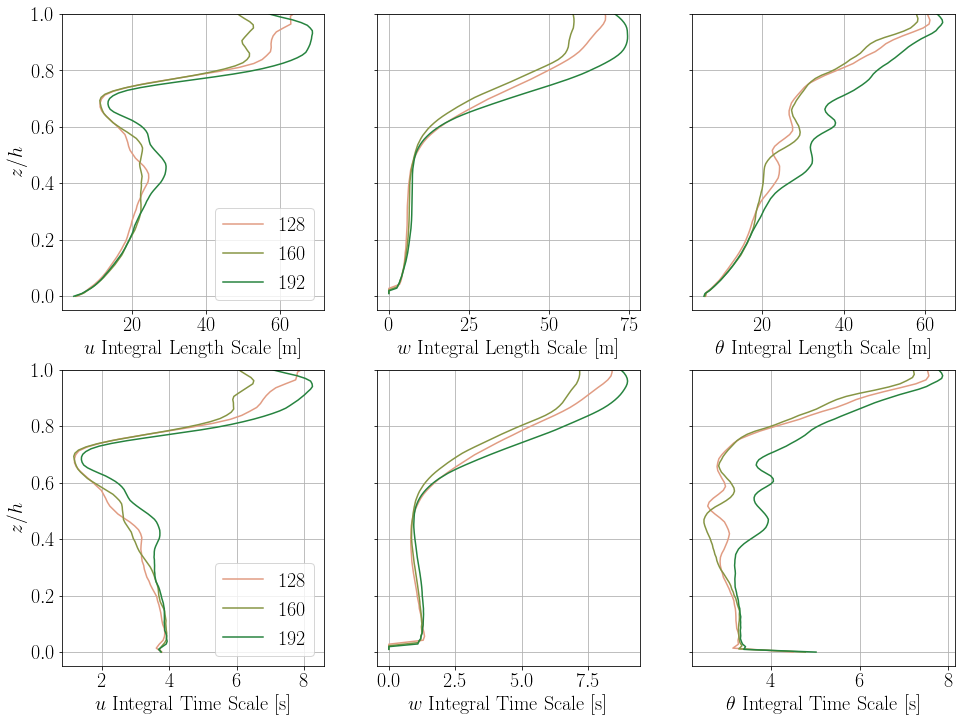

In [219]:
#### define color RGB tuples
colors = [(225./255, 156./255, 131./255),
          (134./255, 149./255, 68./255), (38./255, 131./255, 63./255),
          (0., 85./255, 80./255), (20./255, 33./255, 61./255), (252./255, 193./255, 219./255)]
# create figure and axes handles
fig1, ax1 = plt.subplots(nrows=2,ncols=3, sharey=True, figsize=(16, 12))
# loop through resolutions
for i, res in enumerate(resolutions):
    # row 1: length scales
    # u length scale
    ax1[0,0].plot(u_len[res], z[res]/h[res], color=colors[i], linestyle="-", label=res)
    # w length scale
    ax1[0,1].plot(w_len[res], z[res]/h[res], color=colors[i], linestyle="-", label=res)
    # theta length scale
    ax1[0,2].plot(theta_len[res], z[res]/h[res], color=colors[i], linestyle="-", label=res)
    # row 2: time scales
    # u length scale
    ax1[1,0].plot(u_ts[res], z[res]/h[res], color=colors[i], linestyle="-", label=res)
    # w length scale
    ax1[1,1].plot(w_ts[res], z[res]/h[res], color=colors[i], linestyle="-", label=res)
    # theta length scale
    ax1[1,2].plot(theta_ts[res], z[res]/h[res], color=colors[i], linestyle="-", label=res)
    
# format figures
# u length scale
ax1[0,0].set_xlabel("$u$ Integral Length Scale [m]")
ax1[0,0].set_ylabel("$z/h$")
ax1[0,0].grid()
ax1[0,0].legend()
ax1[0,0].set_ylim([-0.05, 1.])
# w length scale
ax1[0,1].set_xlabel("$w$ Integral Length Scale [m]")
ax1[0,1].grid()
# theta length scale
ax1[0,2].set_xlabel("$\\theta$ Integral Length Scale [m]")
ax1[0,2].grid()
# u time scale
ax1[1,0].set_xlabel("$u$ Integral Time Scale [s]")
ax1[1,0].set_ylabel("$z/h$")
ax1[1,0].grid()
ax1[1,0].legend()
# w time scale
ax1[1,1].set_xlabel("$w$ Integral Time Scale [s]")
ax1[1,1].grid()
# theta time scale
ax1[1,2].set_xlabel("$\\theta$ Integral Time Scale [s]")
ax1[1,2].grid()

# save figure
fdir_save = "/home/bgreene/Python/figures/random_errors/"
# fig1.savefig(f"{fdir_save}u_w_theta_lenthscales.pdf", format="pdf", bbox_inches="tight")

Text(0.5, 0.98, 'Relative Random Errors for Averaging Time $T = 3.0$ s')

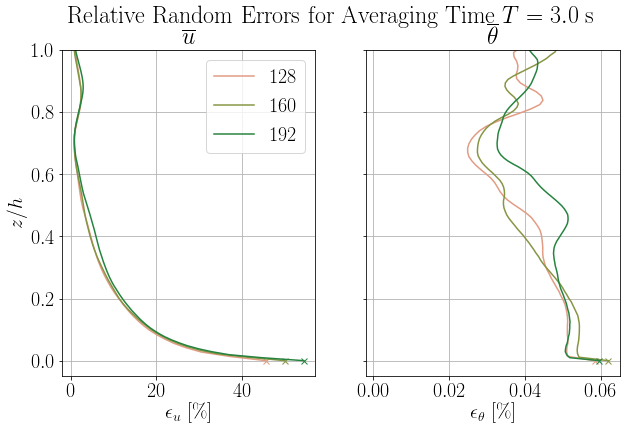

In [220]:
# plot relative random error for u and theta
fig2, ax2 = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 6))
for i, res in enumerate(resolutions):
    # u
    ax2[0].plot(100.*e_u[res], z[res]/h[res], color=colors[i], linestyle="-", label=res)
    ax2[0].plot(100.*e_u[res][0], z[res][0]/h[res], color=colors[i], linestyle="-", marker="x")
    # theta
    ax2[1].plot(100.*e_theta[res], z[res]/h[res], color=colors[i], linestyle="-", label=res)
    ax2[1].plot(100.*e_theta[res][0], z[res][0]/h[res], color=colors[i], linestyle="-", marker="x")

# format subplots
# u
ax2[0].set_xlabel("$\epsilon_u$ [\%]")
ax2[0].set_ylabel("$z/h$")
ax2[0].grid()
ax2[0].legend()
ax2[0].set_title("$\overline{u}$")
ax2[0].set_ylim([-0.05, 1.])
# theta
ax2[1].set_xlabel("$\epsilon_\\theta$ [\%]")
ax2[1].grid()
ax2[1].set_title("$\overline{\\theta}$")

fig2.suptitle(f"Relative Random Errors for Averaging Time $T = {T}$ s")

# save figure
# fig2.savefig(f"{fdir_save}u_theta_errors.pdf", format="pdf", bbox_inches="tight")

In [ ]:
thetavar

In [ ]:
dat["u_corr"]

In [ ]:
plt.plot(dat["u_corr"][:,60])
# plt.axhline(0.)

In [ ]:
40.*400./255

In [27]:
u_len

{'128': array([ 5.0769178 ,  7.10465318,  8.38746054,  9.8003044 , 10.96208428,
        11.98728188, 12.88790862, 13.6288799 , 14.40318381, 15.16324742,
        15.88647979, 16.54162454, 17.17159539, 17.71793856, 18.31506986,
        18.6965024 , 19.01962397, 19.33603232, 19.71378064, 19.94724775,
        20.31789063, 20.65908434, 21.09512047, 21.36004839, 21.77205739,
        22.28023387, 22.65099859, 23.18951536, 23.7701916 , 24.32266371,
        24.50393566, 24.46114986, 23.93848723, 23.15846583, 22.02530817,
        20.9222427 , 20.20110022, 19.45003387, 19.06458824, 18.81862341,
        18.46351194, 18.06611913, 17.0474079 , 16.05044986, 14.89700899,
        13.74344314, 12.6234483 , 11.76532649, 11.33139767, 11.34413858,
        11.70447225, 12.62125497, 15.00908564, 18.95075016, 24.02902861,
        30.49989449, 37.14315548, 43.504143  , 48.96387498, 52.95937018,
        55.22817764, 56.43868517, 57.47752125, 57.68172876, 57.63786721,
        57.78860047, 58.20222471, 59.0634054

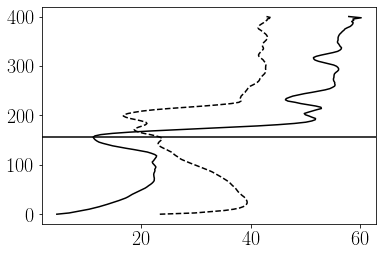

In [61]:
dd = np.load("/home/bgreene/Python/LES/scripts/SBL/filtered_lengthscale_A_160_v2.npz")    
len_u = dd["len_u"]
wspd = np.sqrt(stats[:,1]**2. + stats[:,2]**2.)
zllj = z["160"][np.argmax(wspd)]

plt.plot(u_len["160"], z["160"], "-k")
plt.plot(len_u, z["160"], "--k")
plt.axhline(zllj, c="k", ls="-")

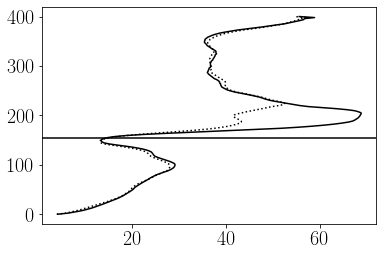

In [223]:
# dd = np.load("/home/bgreene/Python/LES/scripts/SBL/filtered_lengthscale_A_128_v2.npz")    
# len_u = dd["len_u"]
fstats = f"/home/bgreene/simulations/A_192_interp/output/average_statistics.csv"
stats = np.genfromtxt(fstats, delimiter=",", skip_header=1)
wspd = np.sqrt(stats[:,1]**2. + stats[:,2]**2.)
zllj = z["192"][np.argmax(wspd)]
dd2 = np.load("/home/bgreene/Python/LES/scripts/SBL/filtered_lengthscale_A_192.npz")
len_u_2 = dd2["len_u"]
len_theta = dd2["len_theta"]

plt.plot(u_len["192"], z["192"], "-k")
# plt.plot(len_u, z["128"], "--k")
plt.plot(len_u_2, z["192"], ":k")
plt.axhline(zllj, c="k", ls="-")

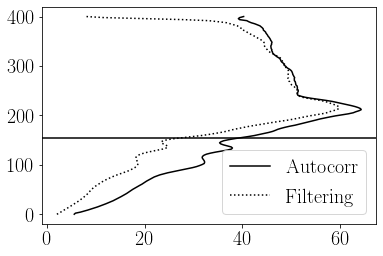

In [224]:
plt.plot(theta_len["192"], z["192"], "-k", label="Autocorr")
plt.plot(len_theta, z["192"], ":k", label="Filtering")
plt.axhline(zllj, c="k", ls="-")
plt.legend()

Beginning loading data for 192^3 simulation--
Reading file: /home/bgreene/simulations/A_192_interp/output/average_statistics.csv


Text(0.5, 1.0, 'F 128 u')

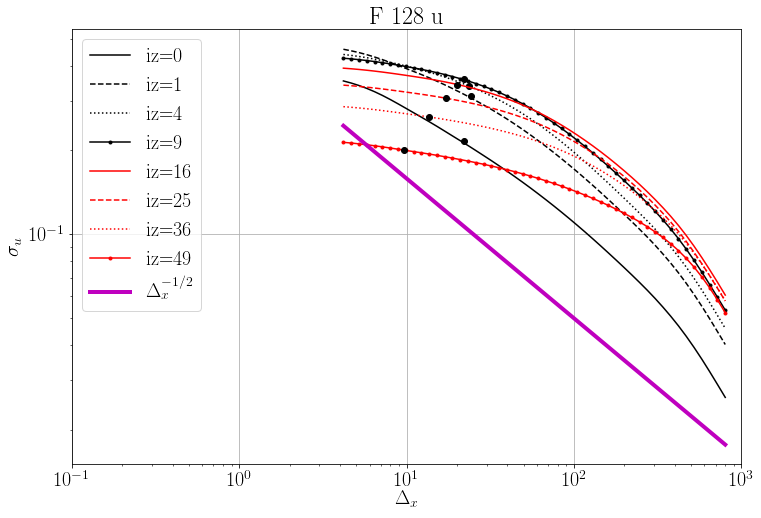

In [86]:
dd2 = np.load("/home/bgreene/SBL_LES/output/filtered_lengthscale_A_192_full.npz")
# dd2 = np.load("/home/bgreene/archive/Python/LES/scripts/SBL/filtered_lengthscale_A_128_v3.npz")
fstats = f"/home/bgreene/simulations/A_192_interp/output/average_statistics.csv"
stats = np.genfromtxt(fstats, delimiter=",", skip_header=1)
wspd = np.sqrt(stats[:,1]**2. + stats[:,2]**2.)
# create sim object to get Lo
s128F = simulation("/home/bgreene/simulations/A_192_interp/output/average_statistics.csv",
                  192, 192, 192, 800., 800., 400., "F")
s128F.read_csv()
s128F.calc_Ri()
s128F.calc_most()

fstr = ["-k", "--k", ":k", ".-k", "-r", "--r", ":r", ".-r", "-b", "--b", ":b", ".-b"]

fig00, ax00 = plt.subplots(1, figsize=(12, 8))
for i, j in enumerate(np.arange(8, dtype=int)**2):
    ax00.plot(dd2["delta_x"], dd2["sigma_u"][j,:], fstr[i], label=f"iz={j}")
    i_dx = np.argmin([abs(s128F.Ri["Lo"][j] - xx) for xx in dd2["delta_x"]])
    ax00.plot(s128F.Ri["Lo"][j], dd2["sigma_u"][j,i_dx], "ok")

# ax00.axvline(dd2["dx"], c="r", lw=4)
# ax00.axvline(dd2["Lx"], c="r", lw=4)
# ax00.axvline(dd2["dx"]*4, c="k", lw=4)
# ax00.axvline(dd2["Lx"]/5., c="k", lw=4)
ax00.plot(dd2["delta_x"], 0.5*(dd2["delta_x"])**-0.5, linewidth=4, c="m", label="$\Delta_x^{-1/2}$")
ax00.set_xscale("log")
ax00.set_yscale("log")
ax00.set_xlim([0.1, 1000])
# ax00.set_ylim([0.005, 0.5])
ax00.legend()
ax00.grid()
# ax00.set_xlabel("$\Delta_x / \mathcal{L}_u$")
# ax00.set_ylabel("$\sigma_u \ \Delta_x^{1/2}$")
ax00.set_xlabel("$\Delta_x$")
ax00.set_ylabel("$\sigma_u$")
ax00.set_title("F 128 u")

# ax00.annotate('$dx$', xy=(dd2["dx"], 0.008), xytext=(dd2["dx"], 0.008), rotation=270)
# ax00.annotate('$L_x$', xy=(dd2["Lx"], 0.008), xytext=(dd2["Lx"], 0.008), rotation=270)

In [57]:
stats[:,0][40]

127.55905512

Text(0.5, 1.0, 'F 128 theta')

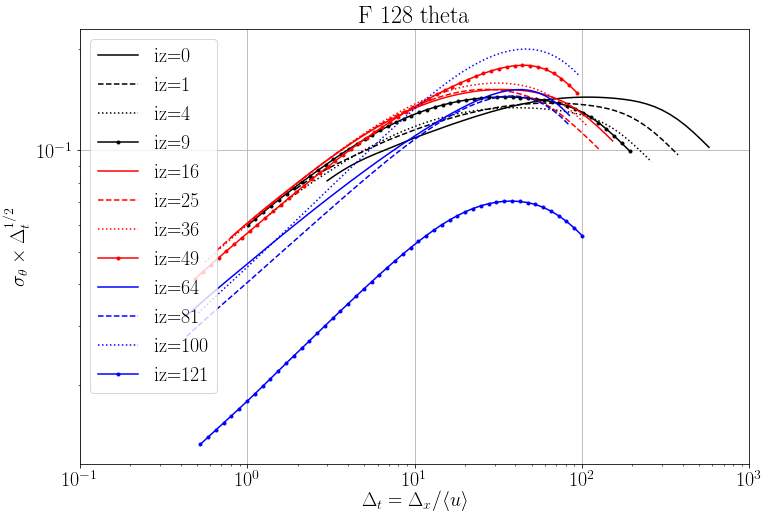

In [85]:
dd2 = np.load("/home/bgreene/SBL_LES/output/filtered_lengthscale_A_192_full.npz")
fstats = f"/home/bgreene/simulations/A_192_interp/output/average_statistics.csv"
stats = np.genfromtxt(fstats, delimiter=",", skip_header=1)
wspd = np.sqrt(stats[:,1]**2. + stats[:,2]**2.)

fstr = ["-k", "--k", ":k", ".-k", "-r", "--r", ":r", ".-r", "-b", "--b", ":b", ".-b", "-m", "--m", ":m", ".-m"]

fig00, ax00 = plt.subplots(1, figsize=(12, 8))
for i, j in enumerate(np.arange(12, dtype=int)**2):
    ax00.plot(dd2["delta_x"]/wspd[j], dd2["sigma_theta"][j,:]*(dd2["delta_x"]/wspd[j])**0.5, fstr[i], label=f"iz={j}")

# ax00.axvline(dd2["dx"], c="r", lw=4)
# ax00.axvline(dd2["Lx"], c="r", lw=4)
# ax00.axvline(dd2["dx"]*4, c="k", lw=4)
# ax00.axvline(dd2["Lx"]/5., c="k", lw=4)
# ax00.plot(dd2["delta_x"]/wspd[j], 0.1*(dd2["delta_x"]/wspd[j])**-0.5, linewidth=4, c="m", label="$\Delta_x^{-1/2}$")
ax00.set_xscale("log")
ax00.set_yscale("log")
ax00.set_xlim([0.1, 1000])
# ax00.set_ylim([0.005, 0.5])
ax00.legend()
ax00.grid()
ax00.set_xlabel("$\Delta_t = \Delta_x / \\langle u \\rangle$")
ax00.set_ylabel("$\sigma_{\\theta} \\times \Delta_t^{1/2}$")
ax00.set_title("F 128 theta")

# ax00.annotate('$dx$', xy=(dd2["dx"], 0.008), xytext=(dd2["dx"], 0.008), rotation=270)
# ax00.annotate('$L_x$', xy=(dd2["Lx"], 0.008), xytext=(dd2["Lx"], 0.008), rotation=270)

In [205]:
i, j

(11, 121)

In [163]:
96*2

192

In [208]:
dd2["sigma_u"].shape

(192, 50)

In [198]:
96/4

24.0

In [96]:
os.system("pwd")

0